In [1]:
import cv2
import numpy as np
import os
from tqdm import * #進度條
import matplotlib.pyplot as plt
import tensorflow as tf 
import keras.models
import keras.backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils import *
from keras.callbacks import *

Using TensorFlow backend.


In [2]:
def get_ImgName(path):
    data=[]
    with open(path, 'r',encoding="utf-8") as f:
        for line in f.readlines():
            data.append(line.strip())
    return data
    

In [3]:
def get_imgclass():
    class_path=r"D:\\yucheng\\Inception v4\\class_yellowsticky_Origin_20201203\\分類.txt"
    classes=[]
    
    with open(class_path, 'r',encoding="utf-8") as f:
        for line in f.readlines():
            classes.append(line.strip())
    return classes
    

In [4]:
def labellist_to_One_hot(label):
    one_hot=[]
    for i in range(len(label)):
        arr=np.zeros(len(label), dtype=np.int)
        arr[i]=1
        one_hot.append(arr)
    one_hot=np.array(one_hot)  
    return one_hot
    

In [5]:
def get_one_hot_label(label):
    label_list=get_imgclass()
    one_hot=labellist_to_One_hot(label_list)
    for i in range(len(label_list)):
        if label==label_list[i]:
            return one_hot[i]
            break

In [6]:
def get_data(img_folder,ImgName_path):
    img_name=get_ImgName(ImgName_path)
    data=[]
    for i in trange(len(img_name)):
        label=None
        img=cv2.imdecode(np.fromfile(img_folder+img_name[i],dtype=np.uint8),cv2.IMREAD_COLOR) #等同=cv2.imread
        img=cv2.resize(img,(299,299))
        
        #取得img_label
        for j in range(len(img_name[i])):
            if '_' == img_name[i][j]:
                label=img_name[i][0:j]
                label=get_one_hot_label(label)
                break
        data.append([img,label])
        
    X=np.array([i[0] for i in data]).reshape(-1,299,299,3)
    Y=np.array([i[1] for i in data])
    
    return X,Y

# 建立CNN(googlNet)模型，基於inception_4的模塊

In [7]:
CONV_BLOCK_COUNT = 0  # 用来命名计数卷积编号
INCEPTION_A_COUNT = 0
INCEPTION_B_COUNT = 0
INCEPTION_C_COUNT = 0

In [8]:
def conv_block(x, nb_filters, nb_row, nb_col, strides=(1, 1), padding='same', use_bias=False):
    global CONV_BLOCK_COUNT
    CONV_BLOCK_COUNT += 1
    with K.name_scope('conv_block_'+str(CONV_BLOCK_COUNT)):
        x = Conv2D(filters=nb_filters,
                   kernel_size=(nb_row, nb_col),
                   strides=strides,
                   padding=padding,
                   use_bias=use_bias)(x)
        x = BatchNormalization(axis=-1, momentum=0.9, scale=False)(x)
        x = Activation("relu")(x)
    return x

In [9]:
def stem(x_input):
    with K.name_scope('stem'):
        x = conv_block(x_input, 32, 3, 3, strides=(2, 2), padding='valid')
        x = conv_block(x, 32, 3, 3, padding='valid')
        x = conv_block(x, 64, 3, 3)
 
        x1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(x)
        x2 = conv_block(x, 96, 3, 3, strides=(2, 2), padding='valid')
 
        x = concatenate([x1, x2], axis=-1)
 
        x1 = conv_block(x, 64, 1, 1)
        x1 = conv_block(x1, 96, 3, 3, padding='valid')
 
        x2 = conv_block(x, 64, 1, 1)
        x2 = conv_block(x2, 64, 7, 1)
        x2 = conv_block(x2, 64, 1, 7)
        x2 = conv_block(x2, 96, 3, 3, padding='valid')
 
        x = concatenate([x1, x2], axis=-1)
 
        x1 = conv_block(x, 192, 3, 3, strides=(2, 2), padding='valid')
        x2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(x)
 
        merged_vector = concatenate([x1, x2], axis=-1)
    return merged_vector

In [10]:
def inception_A(x_input):
    """35*35 卷积块"""
    global INCEPTION_A_COUNT
    INCEPTION_A_COUNT += 1
    with K.name_scope('inception_A' + str(INCEPTION_A_COUNT)):
        averagepooling_conv1x1 = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x_input)  # 35 * 35 * 192
        averagepooling_conv1x1 = conv_block(averagepooling_conv1x1, 96, 1, 1)  # 35 * 35 * 96
 
        conv1x1 = conv_block(x_input, 96, 1, 1)  # 35 * 35 * 96
 
        conv1x1_3x3 = conv_block(x_input, 64, 1, 1)  # 35 * 35 * 64
        conv1x1_3x3 = conv_block(conv1x1_3x3, 96, 3, 3)  # 35 * 35 * 96
 
        conv3x3_3x3 = conv_block(x_input, 64, 1, 1)  # 35 * 35 * 64
        conv3x3_3x3 = conv_block(conv3x3_3x3, 96, 3, 3)  # 35 * 35 * 96
        conv3x3_3x3 = conv_block(conv3x3_3x3, 96, 3, 3)  # 35 * 35 * 96
 
        merged_vector = concatenate([averagepooling_conv1x1, conv1x1, conv1x1_3x3, conv3x3_3x3], axis=-1)  # 35 * 35 * 384
    return merged_vector

In [11]:
def inception_B(x_input):
    """17*17 卷积块"""
    global INCEPTION_B_COUNT
    INCEPTION_B_COUNT += 1
    with K.name_scope('inception_B' + str(INCEPTION_B_COUNT)):
        averagepooling_conv1x1 = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x_input)
        averagepooling_conv1x1 = conv_block(averagepooling_conv1x1, 128, 1, 1)
 
        conv1x1 = conv_block(x_input, 384, 1, 1)
 
        conv1x7_1x7 = conv_block(x_input, 192, 1, 1)
        conv1x7_1x7 = conv_block(conv1x7_1x7, 224, 1, 7)
        conv1x7_1x7 = conv_block(conv1x7_1x7, 256, 1, 7)
 
        conv2_1x7_7x1 = conv_block(x_input, 192, 1, 1)
        conv2_1x7_7x1 = conv_block(conv2_1x7_7x1, 192, 1, 7)
        conv2_1x7_7x1 = conv_block(conv2_1x7_7x1, 224, 7, 1)
        conv2_1x7_7x1 = conv_block(conv2_1x7_7x1, 224, 1, 7)
        conv2_1x7_7x1 = conv_block(conv2_1x7_7x1, 256, 7, 1)
 
        merged_vector = concatenate([averagepooling_conv1x1, conv1x1, conv1x7_1x7, conv2_1x7_7x1], axis=-1)
    return merged_vector

In [12]:
def inception_C(x_input):
    """8*8 卷积块"""
    global INCEPTION_C_COUNT
    INCEPTION_C_COUNT += 1
    with K.name_scope('Inception_C' + str(INCEPTION_C_COUNT)):
        averagepooling_conv1x1 = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x_input)
        averagepooling_conv1x1 = conv_block(averagepooling_conv1x1, 256, 1, 1)
 
        conv1x1 = conv_block(x_input, 256, 1, 1)
 
        # 用 1x3 和 3x1 替代 3x3
        conv3x3_1x1 = conv_block(x_input, 384, 1, 1)
        conv3x3_1 = conv_block(conv3x3_1x1, 256, 1, 3)
        conv3x3_2 = conv_block(conv3x3_1x1, 256, 3, 1)
 
        conv2_3x3_1x1 = conv_block(x_input, 384, 1, 1)
        conv2_3x3_1x1 = conv_block(conv2_3x3_1x1, 448, 1, 3)
        conv2_3x3_1x1 = conv_block(conv2_3x3_1x1, 512, 3, 1)
        conv2_3x3_1x1_1 = conv_block(conv2_3x3_1x1, 256, 3, 1)
        conv2_3x3_1x1_2 = conv_block(conv2_3x3_1x1, 256, 1, 3)
 
        merged_vector = concatenate([averagepooling_conv1x1, conv1x1, conv3x3_1, conv3x3_2, conv2_3x3_1x1_1, conv2_3x3_1x1_2], axis=-1)
    return merged_vector

In [13]:
def reduction_A(x_input, k=192, l=224, m=256, n=384):
    with K.name_scope('Reduction_A'):
        """Architecture of a 35 * 35 to 17 * 17 Reduction_A block."""
        maxpool = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(x_input)
 
        conv3x3 = conv_block(x_input, n, 3, 3, strides=(2, 2), padding='valid')
 
        conv2_3x3 = conv_block(x_input, k, 1, 1)
        conv2_3x3 = conv_block(conv2_3x3, l, 3, 3)
        conv2_3x3 = conv_block(conv2_3x3, m, 3, 3, strides=(2, 2), padding='valid')
 
        merged_vector = concatenate([maxpool, conv3x3, conv2_3x3], axis=-1)
    return merged_vector

In [14]:
def reduction_B(x_input):
    """Architecture of a 17 * 17 to 8 * 8 Reduction_B block."""
    with K.name_scope('Reduction_B'):
        maxpool = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(x_input)
 
        conv3x3 = conv_block(x_input, 192, 1, 1)
        conv3x3 = conv_block(conv3x3, 192, 3, 3, strides=(2, 2), padding='valid')
 
        conv1x7_7x1_3x3 = conv_block(x_input, 256, 1, 1)
        conv1x7_7x1_3x3 = conv_block(conv1x7_7x1_3x3, 256, 1, 7)
        conv1x7_7x1a_3x3 = conv_block(conv1x7_7x1_3x3, 320, 7, 1)
        conv1x7_7x1_3x3 = conv_block(conv1x7_7x1_3x3, 320, 3, 3, strides=(2, 2), padding='valid')
 
        merged_vector = concatenate([maxpool, conv3x3, conv1x7_7x1_3x3], axis=-1)
    return merged_vector

In [15]:
def inception_v4_backbone(nb_classes=69, load_weights=True):
    x_input = Input(shape=(299, 299, 3))
    # Stem
    x = stem(x_input)  # 35 x 35 x 384
    # 4 x Inception_A
    for i in range(4):
        x = inception_A(x)  # 35 x 35 x 384
    # Reduction_A
    x = reduction_A(x, k=192, l=224, m=256, n=384)  # 17 x 17 x 1024
    # 7 x Inception_B
    for i in range(7):
        x = inception_B(x)  # 17 x 17 x1024
    # Reduction_B
    x = reduction_B(x)  # 8 x 8 x 1536
    # Average Pooling
    x = AveragePooling2D(pool_size=(8, 8))(x)  # 1536
    # dropout
    x = Dropout(0.2)(x)
    x = Flatten()(x)  # 1536
    # 全连接层
    x = Dense(units=nb_classes, activation='softmax')(x)
    model = Model(inputs=x_input, outputs=x, name='Inception-V4')
    model.save('googlenetV4_classification_ORI_20191017_shuffle.h5')    
    return model

In [16]:
def show_train_history(history, train, test):  
    plt.plot(history.history[train])  
    plt.plot(history.history[test])  
    plt.title('Train History')  
    plt.ylabel(train)  
    plt.xlabel('Epoch')  
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('chart_%s.png'%(train))
    plt.show()  

# main() 

In [17]:
if __name__ == '__main__':
    img_folder=r'D:\\yucheng\\Inception v4\\class_yellowsticky_Origin_20201203\\img\\'
    train_ImgName_path=r"D:\\yucheng\\Inception v4\\class_yellowsticky_Origin_20201203\\training.txt"
    valid_ImgName_path=r"D:\\yucheng\\Inception v4\\class_yellowsticky_Origin_20201203\\vaildation.txt"
    
    #訓練集
    X_train,Y_train=get_data(img_folder,train_ImgName_path)
    #驗證集
    X_valid,Y_valid=get_data(img_folder,valid_ImgName_path)
    
    #開始訓練
    model_path ='D:\\yucheng\\Inception v4\\class_yellowsticky_Origin_20201203\\model\\'

    model_name = "checkpoint-{epoch:02d}e-val_acc_{val_acc:.2f}.hdf5"

    checkpoint = ModelCheckpoint(os.path.join(model_path,model_name),
                                 monitor='val_acc',verbose=1,save_best_only=False, save_weights_only=False,
                                 mode='auto', period=1)
    
    model = inception_v4_backbone()
    plot_model(model, 'inceptionv4_classification_ORI_20201203_shuffle.png', show_shapes=True)

    sgd = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0, nesterov=False) #decay：每次更新後，學習速率隨之衰減的比率
    model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

    model.summary();
    #history = model.fit(x=tr_img_data, y=tr_lbl_data, batch_size=32, epochs=150,verbose=2,shuffle=True,validation_split=0.1)
    history = model.fit(x=X_train, y=Y_train, batch_size=32, epochs=150,verbose=2,shuffle=True,validation_data=(X_valid,Y_valid))
    model.save('googlenetV4_classification_ORI_20201203_shuffle.h5')

    # evaluate the model
    loss, acc = model.evaluate(X_valid, Y_valid, verbose=0)
    print('Test loss:', loss)
    print('Test accuracy:', acc)

100%|███████████████████████████████████████████████████████████████████████████████| 267/267 [00:01<00:00, 165.01it/s]


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

                                                                 max_pooling2d_2[0][0]            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 35, 35, 64)   24576       concatenate_3[0][0]              
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 35, 35, 64)   192         conv2d_16[0][0]                  
__________________________________________________________________________________________________
activation_16 (Activation)      (None, 35, 35, 64)   0           batch_normalization_16[0][0]     
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 35, 35, 64)   24576       concatenate_3[0][0]              
__________________________________________________________________________________________________
conv2d_17 

__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 35, 35, 96)   288         conv2d_22[0][0]                  
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, 35, 35, 96)   288         conv2d_25[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 35, 35, 96)   0           batch_normalization_19[0][0]     
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 35, 35, 96)   0           batch_normalization_20[0][0]     
__________________________________________________________________________________________________
activation_22 (Activation)      (None, 35, 35, 96)   0           batch_normalization_22[0][0]     
__________

__________________________________________________________________________________________________
activation_35 (Activation)      (None, 35, 35, 64)   0           batch_normalization_35[0][0]     
__________________________________________________________________________________________________
activation_38 (Activation)      (None, 35, 35, 96)   0           batch_normalization_38[0][0]     
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 35, 35, 96)   36864       average_pooling2d_4[0][0]        
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 35, 35, 96)   36864       concatenate_6[0][0]              
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 35, 35, 96)   55296       activation_35[0][0]              
__________

batch_normalization_51 (BatchNo (None, 17, 17, 224)  672         conv2d_51[0][0]                  
__________________________________________________________________________________________________
activation_46 (Activation)      (None, 17, 17, 192)  0           batch_normalization_46[0][0]     
__________________________________________________________________________________________________
activation_51 (Activation)      (None, 17, 17, 224)  0           batch_normalization_51[0][0]     
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 17, 17, 224)  301056      activation_46[0][0]              
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 17, 17, 224)  351232      activation_51[0][0]              
__________________________________________________________________________________________________
batch_norm

__________________________________________________________________________________________________
activation_57 (Activation)      (None, 17, 17, 224)  0           batch_normalization_57[0][0]     
__________________________________________________________________________________________________
activation_62 (Activation)      (None, 17, 17, 224)  0           batch_normalization_62[0][0]     
__________________________________________________________________________________________________
conv2d_54 (Conv2D)              (None, 17, 17, 128)  131072      average_pooling2d_6[0][0]        
__________________________________________________________________________________________________
conv2d_55 (Conv2D)              (None, 17, 17, 384)  393216      concatenate_9[0][0]              
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 17, 17, 256)  401408      activation_57[0][0]              
__________

batch_normalization_65 (BatchNo (None, 17, 17, 384)  1152        conv2d_65[0][0]                  
__________________________________________________________________________________________________
batch_normalization_68 (BatchNo (None, 17, 17, 256)  768         conv2d_68[0][0]                  
__________________________________________________________________________________________________
batch_normalization_73 (BatchNo (None, 17, 17, 256)  768         conv2d_73[0][0]                  
__________________________________________________________________________________________________
activation_64 (Activation)      (None, 17, 17, 128)  0           batch_normalization_64[0][0]     
__________________________________________________________________________________________________
activation_65 (Activation)      (None, 17, 17, 384)  0           batch_normalization_65[0][0]     
__________________________________________________________________________________________________
activation

                                                                 activation_75[0][0]              
                                                                 activation_78[0][0]              
                                                                 activation_83[0][0]              
__________________________________________________________________________________________________
conv2d_89 (Conv2D)              (None, 17, 17, 192)  196608      concatenate_12[0][0]             
__________________________________________________________________________________________________
batch_normalization_89 (BatchNo (None, 17, 17, 192)  576         conv2d_89[0][0]                  
__________________________________________________________________________________________________
activation_89 (Activation)      (None, 17, 17, 192)  0           batch_normalization_89[0][0]     
__________________________________________________________________________________________________
conv2d_90 

__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 17, 17, 192)  196608      concatenate_13[0][0]             
__________________________________________________________________________________________________
conv2d_101 (Conv2D)             (None, 17, 17, 224)  301056      activation_100[0][0]             
__________________________________________________________________________________________________
batch_normalization_96 (BatchNo (None, 17, 17, 192)  576         conv2d_96[0][0]                  
__________________________________________________________________________________________________
batch_normalization_101 (BatchN (None, 17, 17, 224)  672         conv2d_101[0][0]                 
__________________________________________________________________________________________________
activation_96 (Activation)      (None, 17, 17, 192)  0           batch_normalization_96[0][0]     
__________

conv2d_112 (Conv2D)             (None, 17, 17, 224)  351232      activation_111[0][0]             
__________________________________________________________________________________________________
batch_normalization_107 (BatchN (None, 17, 17, 224)  672         conv2d_107[0][0]                 
__________________________________________________________________________________________________
batch_normalization_112 (BatchN (None, 17, 17, 224)  672         conv2d_112[0][0]                 
__________________________________________________________________________________________________
average_pooling2d_11 (AveragePo (None, 17, 17, 1024) 0           concatenate_14[0][0]             
__________________________________________________________________________________________________
activation_107 (Activation)     (None, 17, 17, 224)  0           batch_normalization_107[0][0]    
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 69)           106053      flatten_1[0][0]                  
Total params: 26,852,677
Trainable params: 26,809,733
Non-trainable params: 42,944
__________________________________________________________________________________________________
Train on 2397 samples, validate on 267 samples
Epoch 1/150
 - 52s - loss: 3.1723 - acc: 0.3538 - val_loss: 3.8656 - val_acc: 0.3446
Epoch 2/150
 - 38s - loss: 2.7822 - acc: 0.3942 - val_loss: 3.0152 - val_acc: 0.3521
Epoch 3/150
 - 38s - loss: 2.6581 - acc: 0.3926 - val_loss: 2.5085 - val_acc: 0.3933
Epoch 4/150
 - 38s - loss: 2.6056 - acc: 0.4109 - val_loss: 3.2691 - val_acc: 0.3745
Epoch 5/150
 - 38s - loss: 2.5295 - acc: 0.4193 - val_loss: 2.4082 - val_acc: 0.4045
Epoch 6/150
 - 38s - loss: 2.3455 - acc: 0.4326 - val_loss: 2.2520 - val_acc: 0.4007
Epoch 7/150
 - 38s - loss: 2.2894 - acc: 0.4443 - val_loss: 2.1

Epoch 91/150
 - 38s - loss: 0.0399 - acc: 0.9875 - val_loss: 1.6532 - val_acc: 0.7341
Epoch 92/150
 - 38s - loss: 0.0288 - acc: 0.9908 - val_loss: 1.5229 - val_acc: 0.7378
Epoch 93/150
 - 39s - loss: 0.0210 - acc: 0.9950 - val_loss: 1.7396 - val_acc: 0.7341
Epoch 94/150
 - 39s - loss: 0.0420 - acc: 0.9871 - val_loss: 1.5954 - val_acc: 0.7341
Epoch 95/150
 - 39s - loss: 0.0409 - acc: 0.9887 - val_loss: 1.9147 - val_acc: 0.7079
Epoch 96/150
 - 39s - loss: 0.0575 - acc: 0.9804 - val_loss: 1.6585 - val_acc: 0.7266
Epoch 97/150
 - 39s - loss: 0.0398 - acc: 0.9908 - val_loss: 1.7547 - val_acc: 0.7191
Epoch 98/150
 - 39s - loss: 0.0198 - acc: 0.9921 - val_loss: 1.7041 - val_acc: 0.7228
Epoch 99/150
 - 39s - loss: 0.0186 - acc: 0.9946 - val_loss: 1.7545 - val_acc: 0.7491
Epoch 100/150
 - 39s - loss: 0.0121 - acc: 0.9971 - val_loss: 1.7222 - val_acc: 0.7378
Epoch 101/150
 - 39s - loss: 0.0115 - acc: 0.9979 - val_loss: 1.7735 - val_acc: 0.7228
Epoch 102/150
 - 39s - loss: 0.0257 - acc: 0.9921 - 

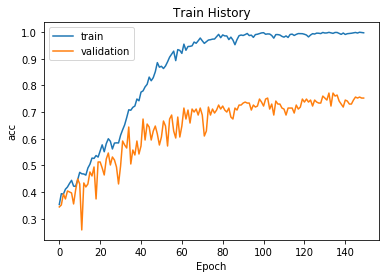

In [19]:
    show_train_history(history, 'acc', 'val_acc') 

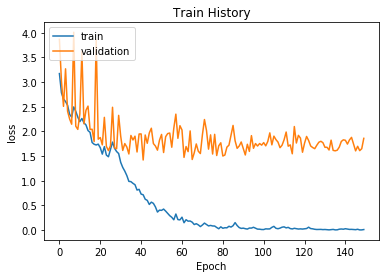

In [20]:
    show_train_history(history, 'loss', 'val_loss') 